In [101]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import pandas as pd
import pickle

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow import keras

# import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.models import Model



#importing tensorflow
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,MaxPool1D,concatenate,Embedding,BatchNormalization
from keras.layers import CuDNNLSTM,SpatialDropout1D,GlobalMaxPooling1D,GlobalAveragePooling1D,Concatenate,Add,CuDNNGRU
from tensorflow.keras.models import Model,Sequential
import random as rn


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [103]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

> loding data

In [ ]:
Train_Final_pre_text_data_DL = pd.read_csv(r"C:\Users\Lenovo\Downloads\Self case study 2\Train_Final_pre_text_data_DL_1.csv")

In [52]:
## Droping NAN values
Train_Final_pre_text_data_DL.dropna(subset = ["comment_text_pre"],inplace=True)

In [53]:
Train_Final_pre_text_data_DL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797911 entries, 0 to 1804873
Data columns (total 47 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

> Splliting data 

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_train, x_test, y_train, y_test = train_test_split(Train_Final_pre_text_data_DL, Train_Final_pre_text_data_DL['class'].values, test_size=0.15,stratify=Train_Final_pre_text_data_DL['class'].values ,random_state=42)

x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train,stratify=y_train, test_size=0.15, random_state=42)

In [55]:
print('shape of x_train :',x_train['comment_text_pre'].values.shape)
print('shape of x_cv :',x_cv['comment_text_pre'].values.shape)
print('shape of  x_test :',x_test['comment_text_pre'].values.shape)

shape of x_train : (1298990,)
shape of x_cv : (229234,)
shape of  x_test : (269687,)


In [56]:
import pickle
with open('train_test_cv_all.pkl', 'wb') as file:
    pickle.dump([x_train , x_cv , x_test, y_train, y_cv, y_test], file)

In [104]:

import pickle
with open('train_test_cv_all.pkl', 'rb') as file:
      
    # Call load method to deserialze
    x_train , x_cv , x_test, y_train_, y_cv_, y_test_ = pickle.load(file)
 

> here i am tokenize data based on x_train (assign token to each unique word) and use same token to padd x_text to avoide data leakage

In [16]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train['comment_text_pre'].values)
word_index_train= tokenizer.word_index

In [19]:
len(word_index_train)

111590

In [11]:
# x_test_submission_sequences = tokenizer.texts_to_sequences(x_train)

> lets calculate maxlen for test data.

In [20]:
lengths = [len(i.split()) for i in x_train['comment_text_pre'].values]

In [21]:
len(lengths)

1298990

> Its recommended that to keep maxlen as  90 percentile of total lengths of all texts. as we also saw in EDA .

In [22]:
# https://www.geeksforgeeks.org/numpy-percentile-in-python/
max_length = np.percentile(lengths, 91)
max_length = int(max_length)
max_length

69

In [17]:
max_length = 69

In [18]:
# storing train tokenizer
import pickle
with open('train_tokenizer.pkl', 'wb') as file:
    pickle.dump([tokenizer,max_length], file)
 

In [ ]:

# import pickle
# with open('train_tokenizer.pkl', 'rb') as file:
      
#     # Call load method to deserialze
#     tokenizer,max_length = pickle.load(file)

In [23]:
x_train_sequences = tokenizer.texts_to_sequences(x_train['comment_text_pre'].values)
x_cv_sequences = tokenizer.texts_to_sequences(x_cv['comment_text_pre'].values)
x_test_sequences = tokenizer.texts_to_sequences(x_test['comment_text_pre'].values)

x_train_padding= pad_sequences(x_train_sequences,padding='pre',maxlen=max_length)
x_cv_padding= pad_sequences(x_cv_sequences,padding='pre',maxlen=max_length)
x_test_padding= pad_sequences(x_test_sequences,padding='pre',maxlen=max_length)


In [24]:
print('x_train_padding:',x_train_padding.shape)
print('x_cv_padding:',x_cv_padding.shape)
print('x_test_padding:',x_test_padding.shape)

x_train_padding: (1298990, 69)
x_cv_padding: (229234, 69)
x_test_padding: (269687, 69)


In [30]:
import pickle
with open('data_Tokeniz.pkl', 'wb') as file:
    pickle.dump([x_train_padding , x_cv_padding , x_test_padding, y_train, y_cv, y_test], file)

In [5]:

import pickle
with open('data_Tokeniz.pkl', 'rb') as file:
      
    # Call load method to deserialze
    x_train_padding , x_cv_padding , x_test_padding, y_train, y_cv, y_test = pickle.load(file)
 

> Glove vectors

In [32]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open(r"C:\Users\Lenovo\Downloads\glove.6B\glove.6B.300d.txt",encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [34]:
word_index=word_index_train
# # word_index

In [35]:
vocab_size=111590+1

In [38]:
from tqdm import tqdm

In [40]:
# create a weight matrix for words in training docs
embedding_matrix =np.zeros((vocab_size, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


100%|██████████████████████████████████████████████████████████████████████| 111590/111590 [00:00<00:00, 438743.94it/s]


In [41]:
with open('glove_300.pickel', 'wb') as f:
    pickle.dump(embedding_matrix, f)

In [6]:

import pickle
with open('glove_300.pickel', 'rb') as file:
    embedding_matrix = pickle.load(file)
 

In [14]:
embedding_matrix.shape

(111591, 300)

> Function which calculate bias AUC

In [8]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]==1]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]==1) & (df[label]=='non-toxic')]
    non_subgroup_positive_examples = df[(df[subgroup]==0) & (df[label]=='toxic')]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]==1)&(df[label]=='toxic')]
    non_subgroup_negative_examples = df[(df[subgroup]==0) & (df[label]=='non-toxic')]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': dataset[subgroup].sum()
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

# identity_columns = subgroup
# MODEL_NAME = 'naive_proba'
# TOXICITY_COLUMN  = 'class'
# bias_metrics_df = compute_bias_metrics_for_model(x_cv_1, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
# bias_metrics_df


> Function which caluclate final_metric (weighted AUC)

In [9]:
TOXICITY_COLUMN = 'class'
TEXT_COLUMN = 'comment_text'
MODEL_NAME = 'naive_proba'
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
# get_final_metric(bias_metrics_df, calculate_overall_auc(x_cv_1, MODEL_NAME))


> function only return that identity/subgroups which occurs

In [10]:
# this function only return that identity/subgroups which occurs
def parameters(x_cv):
    x_cv = x_cv[['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white','class']]
    list_ = x_cv.columns[:24]  # droping class colummn
    subgroup = []
    for i in list_:
        if x_cv[x_cv[i]==1][i].count() >500:
#             print(i,':',x_cv[x_cv[i] ==1][i].count())
            subgroup.append(i)
    return subgroup

> Function to calculate Confusion matrix

In [11]:
## making confusion matrix
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
from sklearn.metrics import confusion_matrix
def confusion__matrix(y_test,Y_predicted):
    cm=confusion_matrix(y_test,Y_predicted)
    print(cm)
    ax= plt.subplot();
    cm_= cm.reshape(4) # count 
    percentage = ((cm_/cm_.sum()).round(4))*100 # in percentage
    group_names_ = ['True Neg ','False Pos','False Neg','True Pos']
    group_names = []
    for i in range(4):
        str_ = group_names_[i] + '\n'+ str(cm_[i]) + '\n'+ str(percentage[i])+"%"
        group_names.append(str_)
#     group_names = ['True Neg ','False Pos','False Neg','True Pos']
    group_names = np.array(group_names).reshape(2,2)
    sns.heatmap(cm, annot=group_names,fmt="",cmap='Blues')
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_ylim(2.0, 0)
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0','1']);
    ax.yaxis.set_ticklabels(['0','1']);

> Function to plot AUC_ROC curve 

In [12]:
def Plot_AUC_ROC_curve(y_test,y_train,x_test_BOW_predicted,x_train_BOW_predicted):
    y_test_= y_test
    y_train_= y_train
    # x_test_BOW_predicted_class_= [0 if i=='non-toxic' else 1 for i in x_test_BOW_predicted_class ]

    fpr_test, tpr_test, threshold_test = roc_curve(y_test_, x_test_BOW_predicted,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train_, x_train_BOW_predicted,pos_label=1)

    
    roc_auc_test = roc_auc_score(y_test,x_test_BOW_predicted)
    roc_auc_train = roc_auc_score(y_train,x_train_BOW_predicted)

    plt.title('Receiver Operating Characteristic')

    plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, 'b', label = 'Train AUC = %0.2f' % roc_auc_train)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'g--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    ## Calculating best threshold  # https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    best_threshold_test= threshold_test[np.argmax(tpr_test - fpr_test)]
    best_threshold_train= threshold_train[np.argmax(tpr_train - fpr_train)]
    return roc_auc_test,roc_auc_train,best_threshold_test,best_threshold_train ## simple AUC score


> ### Some Refrences:
* https://neptune.ai/blog/text-classification-tips-and-tricks-kaggle-competitions
* https://www.kaggle.com/buntyshah/jigsaw-classification-lstm
* https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80568/
* https://medium.com/swlh/jigsaw-unintended-bias-in-toxicity-classification-a-kaggle-case-study-f47938753347
* https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
* https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
* https://www.quora.com/How-does-attention-model-work-using-LSTM

> ## Model : 1
* CuDNNLSTM : 32 followed by 16

In [25]:
import os
os.environ['PYTHONHASHSEED'] = '0'

vocabulary_size = 111590+1

Model_input = Input(shape=(x_train_padding.shape[1],))
x = Embedding(vocabulary_size,output_dim=300,input_length=x_train_padding.shape[1],weights=[embedding_matrix], trainable=False)(Model_input)
x = SpatialDropout1D(0.2)(x)
x1 = Bidirectional(CuDNNLSTM(32, return_sequences=True))(x)
x2 = Bidirectional(CuDNNLSTM(16, return_sequences=True))(x1)
max_pool1 = GlobalMaxPooling1D()(x1)
max_avg1 = GlobalMaxPooling1D()(x2)
conc = Concatenate()([max_pool1, max_avg1])
d1 = Dense(96,activation='relu')(conc)
a = Add()([conc,d1])

d3 = Dense(8, activation='relu')(a)
Model_output = Dense(1,activation='sigmoid')(d3)
Model_LSTM= keras.Model(Model_input, Model_output)
Model_LSTM.summary()
# loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 69)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 69, 300)      33477300    input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 69, 300)      0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 69, 64)       85504       spatial_dropout1d_6[0][0]        
______________________________________________________________________________________________

In [8]:
from keras.utils.vis_utils import plot_model

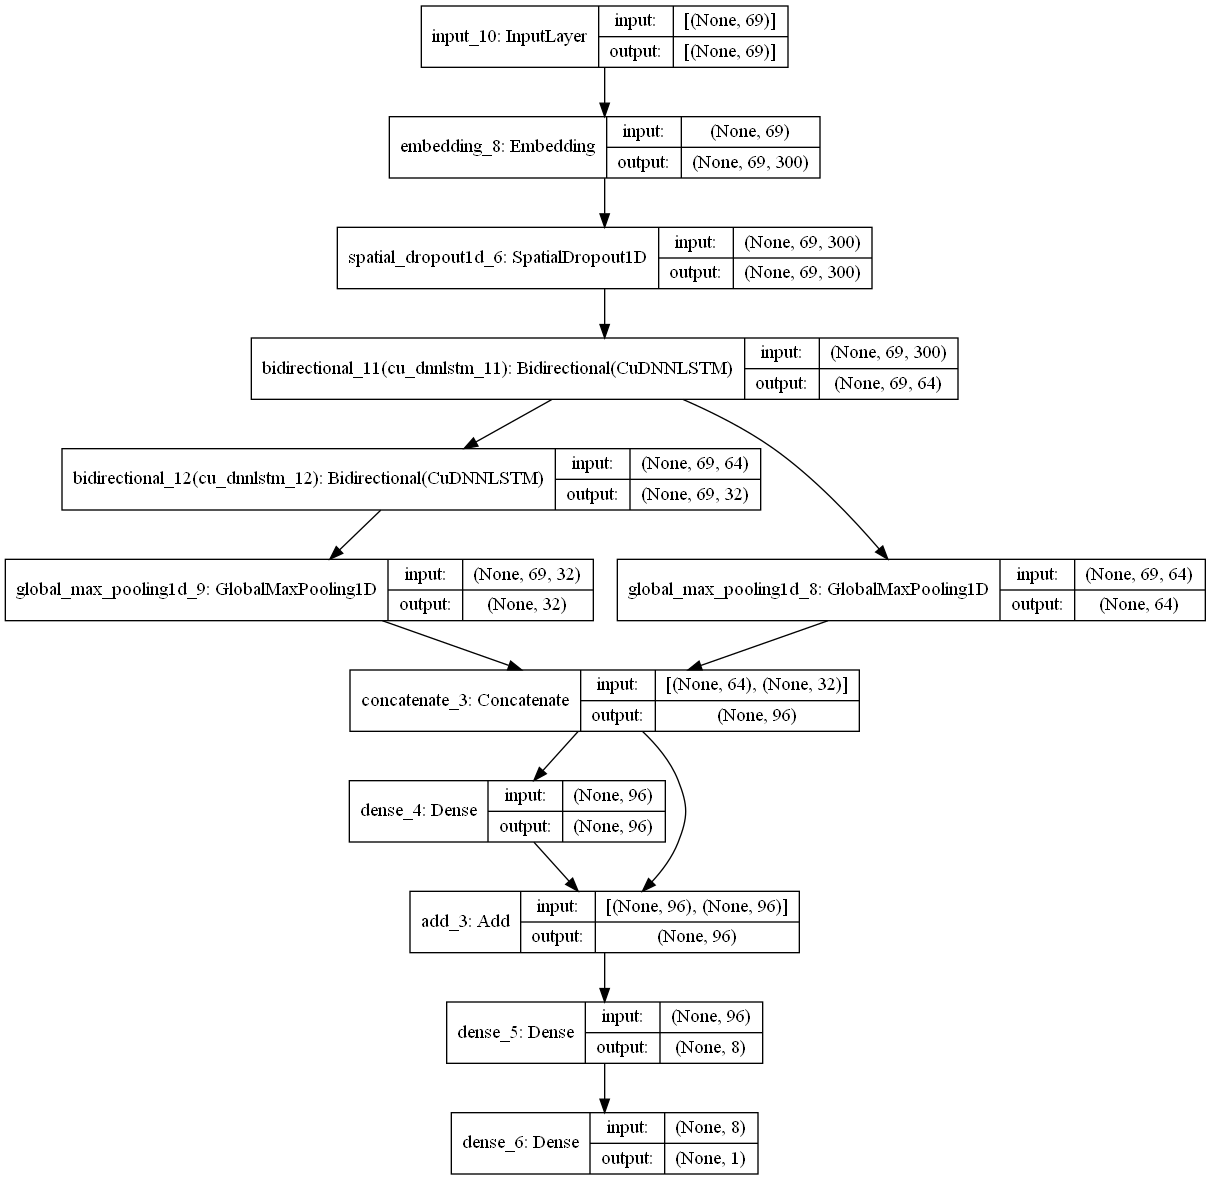

In [29]:
plot_model(Model_LSTM, to_file='Model_LSTM.png', show_shapes=True, show_layer_names=True)

In [32]:
Model_LSTM.compile(loss='binary_crossentropy', optimizer='adam') 

In [68]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_cv = encoder.transform(y_cv)
y_test = encoder.transform(y_test)

In [34]:
history=Model_LSTM.fit(x_train_padding, y_train,
           batch_size=256,
           epochs=10,
           validation_data=(x_cv_padding, y_cv))

Epoch 1/10
5075/5075 [==============================] - 195s 37ms/step - loss: 0.1541 - val_loss: 0.1368
Epoch 2/10
5075/5075 [==============================] - 185s 36ms/step - loss: 0.1384 - val_loss: 0.1333
Epoch 3/10
5075/5075 [==============================] - 179s 35ms/step - loss: 0.1343 - val_loss: 0.1361
Epoch 4/10
5075/5075 [==============================] - 177s 35ms/step - loss: 0.1318 - val_loss: 0.1309 - ETA: 0s - loss:
Epoch 5/10
5075/5075 [==============================] - 170s 34ms/step - loss: 0.1299 - val_loss: 0.1311
Epoch 6/10
5075/5075 [==============================] - 182s 36ms/step - loss: 0.1285 - val_loss: 0.1332
Epoch 7/10
5075/5075 [==============================] - 179s 35ms/step - loss: 0.1271 - val_loss: 0.1314
Epoch 8/10
5075/5075 [==============================] - 183s 36ms/step - loss: 0.1263 - val_loss: 0.1325
Epoch 9/10
5075/5075 [==============================] - 177s 35ms/step - loss: 0.1254 - val_loss: 0.1310los
Epoch 10/10
5075/5075 [===========

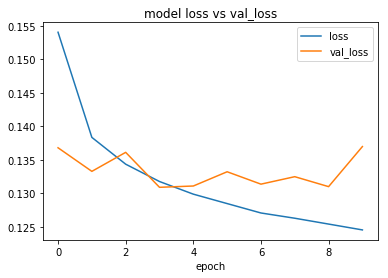

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss vs val_loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show() 

In [37]:
Model_LSTM.save("Model_1.h5")

C:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [13]:
from tqdm import tqdm

In [44]:
# https://stackoverflow.com/questions/68971378/attributeerror-sequential-object-has-no-attribute-predict-proba

#Probability belong to class 1

Model_LSTM_predict_proba_test = Model_LSTM.predict(x_test_padding)
Model_LSTM_predict_proba_train = Model_LSTM.predict(x_train_padding)

In [45]:
Model_LSTM_predict_proba_test = Model_LSTM_predict_proba_test.reshape(Model_LSTM_predict_proba_test.shape[0])
# Model_LSTM_predict_proba_train = Model_LSTM_predict_proba_train.reshape(Model_LSTM_predict_proba_train.shape[0])

In [58]:
x_test.shape

(269687, 47)

In [59]:
x_test['Model_LSTM_predict_proba_test'] = Model_LSTM_predict_proba_test

In [60]:

Model_LSTM_predict_proba_test_0_5 = [1 if i>0.5 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9 = [1 if i>0.9 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9_7 = [1 if i>0.97 else 0 for i in Model_LSTM_predict_proba_test]

> Calculating Weighted AUC

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score


In [63]:
subgroup = parameters(x_test)
identity_columns = subgroup
MODEL_NAME = 'Model_LSTM_predict_proba_test'
TOXICITY_COLUMN  = 'class'
bias_metrics_df = compute_bias_metrics_for_model(x_test, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
AUC_test = get_final_metric(bias_metrics_df, calculate_overall_auc(x_test, MODEL_NAME))

In [64]:
print('weighted AUC on test :',AUC_test)

weighted AUC on test : 0.892369665472569


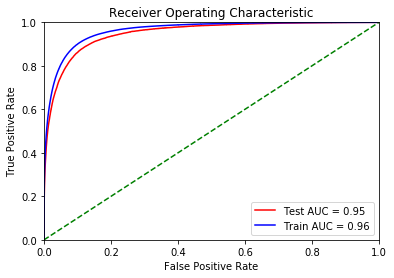

In [69]:
roc_auc_test,roc_auc_train,best_threshold_test,best_threshold_train = Plot_AUC_ROC_curve(y_test,y_train,Model_LSTM_predict_proba_test,Model_LSTM_predict_proba_train)

In [70]:
print('roc_auc_test simple: ',roc_auc_test)
print('roc_auc_train simple : ',roc_auc_train)
print('best_threshold_test : ',best_threshold_test)
print('best_threshold_train : ',best_threshold_train)

roc_auc_test simple:  0.949786342329981
roc_auc_train simple :  0.9629614661675868
best_threshold_test :  0.11160136
best_threshold_train :  0.13481405


> Confusion matrix when threshold = 0.5

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

[[241236   6815]
 [  7618  14018]]


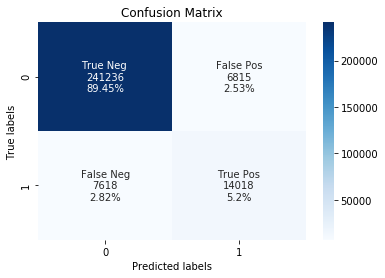

In [72]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_5)

[[247872    179]
 [ 17130   4506]]


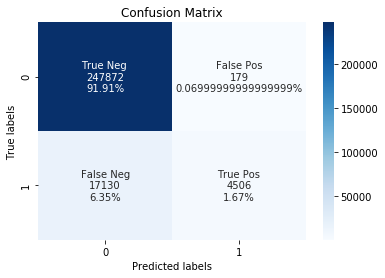

In [75]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_9_7)

> ## Model : 2
* CuDNNLSTM : 128 followed by 128

In [111]:
import os
os.environ['PYTHONHASHSEED'] = '0'

vocabulary_size = 111590+1

Model_input = Input(shape=(x_train_padding.shape[1],))
x = Embedding(vocabulary_size,output_dim=300,input_length=x_train_padding.shape[1],weights=[embedding_matrix], trainable=False)(Model_input)
x = SpatialDropout1D(0.2)(x)
x1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x2 = Bidirectional(CuDNNGRU(128, return_sequences=True))(x1)
max_pool1 = GlobalMaxPooling1D()(x1)
max_avg1 = GlobalMaxPooling1D()(x2)
conc = Concatenate()([max_pool1, max_avg1])
d1 = Dense(512,activation='relu')(conc)
a = Add()([conc,d1])
Dropout_1 = Dropout(0.2, name="dropout_1")(a)
d3 = Dense(34, activation='relu')(Dropout_1)
Model_output = Dense(1,activation='sigmoid')(d3)
Model_LSTM= keras.Model(Model_input, Model_output)
Model_LSTM.summary()
# loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 69)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 69, 300)      33477300    input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 69, 300)      0           embedding_13[0][0]               
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 69, 256)      440320      spatial_dropout1d_11[0][0]       
____________________________________________________________________________________________

In [112]:
from keras.utils.vis_utils import plot_model

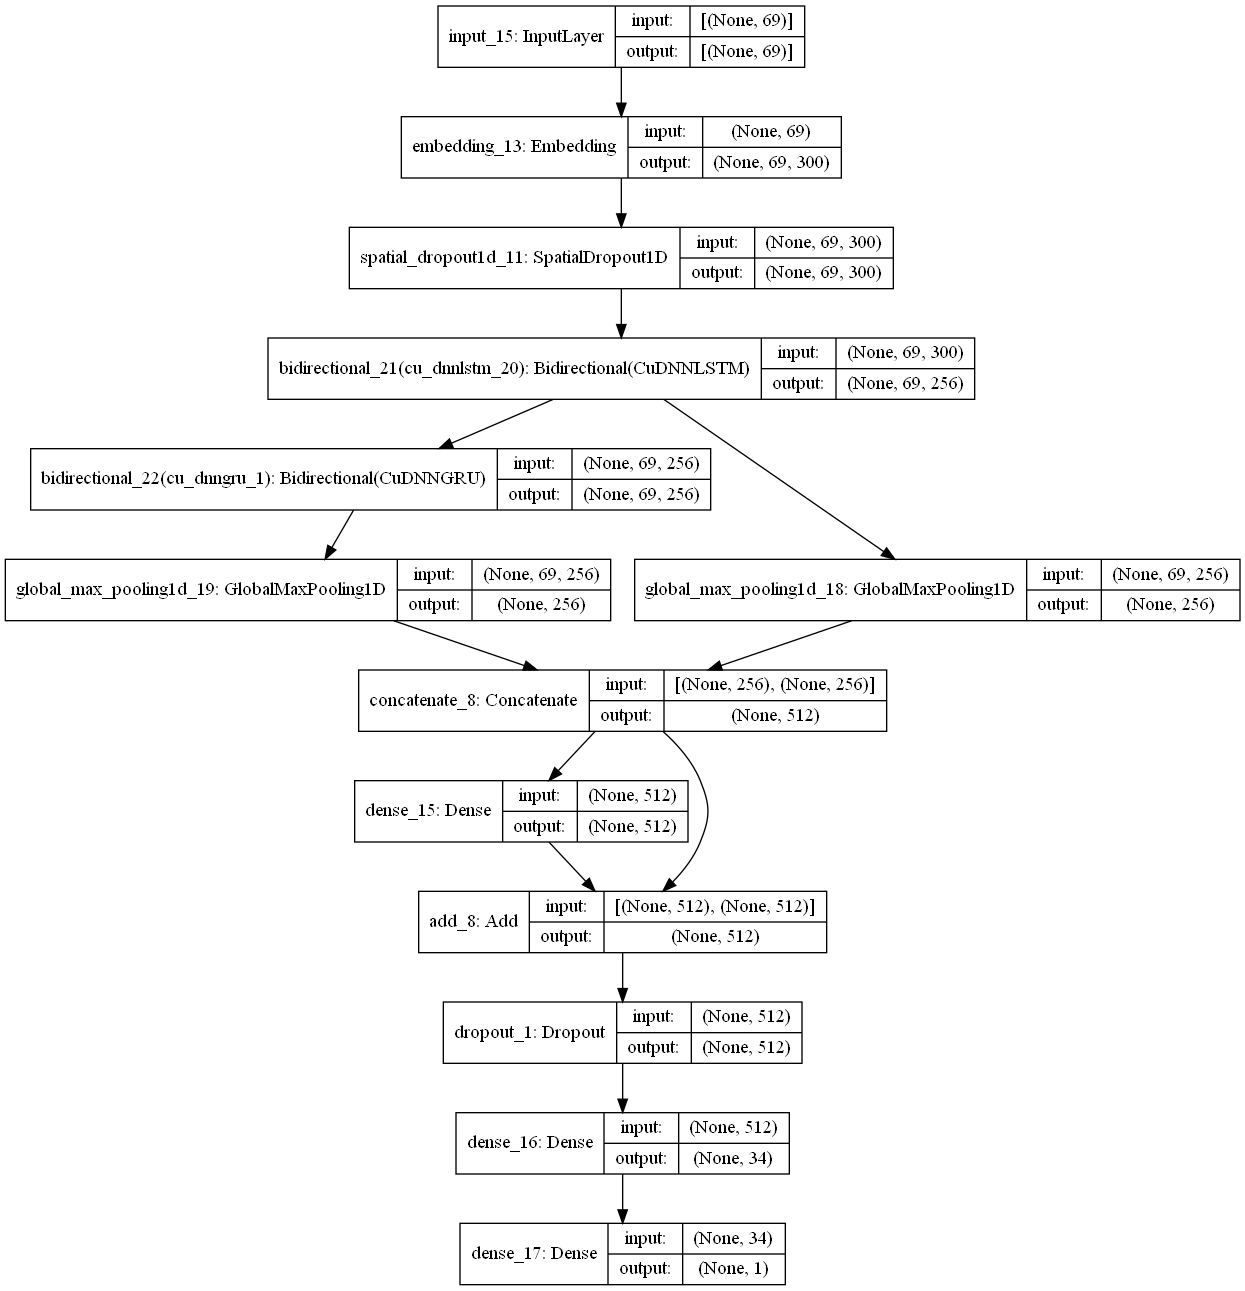

In [113]:
plot_model(Model_LSTM, to_file='Model_LSTM.png', show_shapes=True, show_layer_names=True)

In [114]:
Model_LSTM.compile(loss='binary_crossentropy', optimizer='adam') 

In [115]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_cv = encoder.transform(y_cv)
y_test = encoder.transform(y_test)

In [116]:
from keras.callbacks import ModelCheckpoint

In [117]:
#create callback
filepath = 'my_best_model_2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]


In [118]:
history=Model_LSTM.fit(x_train_padding, y_train,
           batch_size=256,
           epochs=5,
           validation_data=(x_cv_padding, y_cv),callbacks=callbacks)

Epoch 1/5
5075/5075 [==============================] - 388s 76ms/step - loss: 0.1488 - val_loss: 0.1327

Epoch 00001: val_loss improved from inf to 0.13265, saving model to my_best_model_2.hdf5


C:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
5075/5075 [==============================] - 384s 76ms/step - loss: 0.1339 - val_loss: 0.1311

Epoch 00002: val_loss improved from 0.13265 to 0.13105, saving model to my_best_model_2.hdf5
Epoch 3/5
5075/5075 [==============================] - 385s 76ms/step - loss: 0.1283 - val_loss: 0.1310

Epoch 00003: val_loss improved from 0.13105 to 0.13101, saving model to my_best_model_2.hdf5
Epoch 4/5
5075/5075 [==============================] - 387s 76ms/step - loss: 0.1238 - val_loss: 0.1311

Epoch 00004: val_loss did not improve from 0.13101
Epoch 5/5
5075/5075 [==============================] - 388s 77ms/step - loss: 0.1197 - val_loss: 0.1305

Epoch 00005: val_loss improved from 0.13101 to 0.13046, saving model to my_best_model_2.hdf5


In [119]:
#Load and evaluate the best model version
from keras.models import load_model
model_3_load = load_model(filepath)

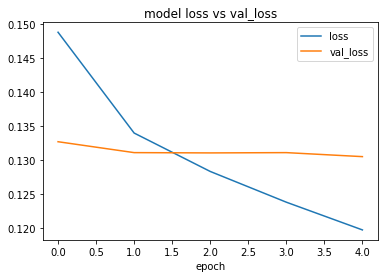

In [120]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss vs val_loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show() 

In [133]:
# https://stackoverflow.com/questions/68971378/attributeerror-sequential-object-has-no-attribute-predict-proba

#Probability belong to class 1

Model_LSTM_predict_proba_test = model_3_load.predict(x_test_padding)
Model_LSTM_predict_proba_train = model_3_load.predict(x_train_padding)

In [134]:
Model_LSTM_predict_proba_test = Model_LSTM_predict_proba_test.reshape(Model_LSTM_predict_proba_test.shape[0])
# Model_LSTM_predict_proba_train = Model_LSTM_predict_proba_train.reshape(Model_LSTM_predict_proba_train.shape[0])

In [135]:
x_test.shape

(269687, 48)

In [136]:
x_test['Model_LSTM_predict_proba_test'] = Model_LSTM_predict_proba_test

In [137]:

Model_LSTM_predict_proba_test_0_5 = [1 if i>0.5 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9 = [1 if i>0.9 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9_7 = [1 if i>0.97 else 0 for i in Model_LSTM_predict_proba_test]

> Calculating Weighted AUC

In [138]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score


In [139]:
subgroup = parameters(x_test)
identity_columns = subgroup
MODEL_NAME = 'Model_LSTM_predict_proba_test'
TOXICITY_COLUMN  = 'class'
bias_metrics_df = compute_bias_metrics_for_model(x_test, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
AUC_test = get_final_metric(bias_metrics_df, calculate_overall_auc(x_test, MODEL_NAME))

In [140]:
print('weighted AUC on test :',AUC_test)

weighted AUC on test : 0.8949292820064356


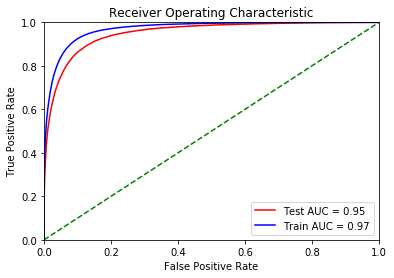

In [141]:
roc_auc_test,roc_auc_train,best_threshold_test,best_threshold_train = Plot_AUC_ROC_curve(y_test,y_train,Model_LSTM_predict_proba_test,Model_LSTM_predict_proba_train)

In [142]:
print('roc_auc_test simple: ',roc_auc_test)
print('roc_auc_train simple : ',roc_auc_train)
print('best_threshold_test : ',best_threshold_test)
print('best_threshold_train : ',best_threshold_train)

roc_auc_test simple:  0.9504022892885209
roc_auc_train simple :  0.9701420562796517
best_threshold_test :  0.06949141
best_threshold_train :  0.09444191


> Confusion matrix when threshold = 0.5

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

[[244123   3928]
 [  9580  12056]]


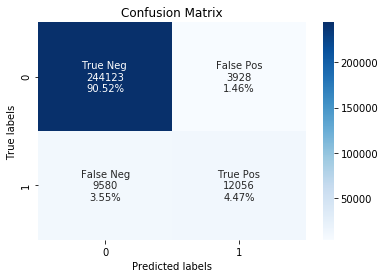

In [147]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_5)

[[247986     65]
 [ 18238   3398]]


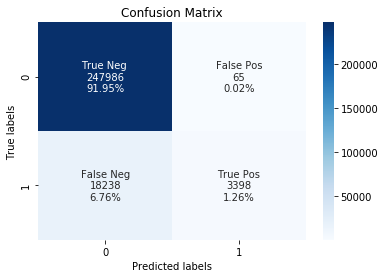

In [148]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_9_7)

> ## Model : 3
* CuDNNLSTM : 128 followed by 128
* 1Dconvolution layer

In [98]:
import os
os.environ['PYTHONHASHSEED'] = '0'

vocabulary_size = 111590+1

Model_input = Input(shape=(x_train_padding.shape[1],))
x = Embedding(vocabulary_size,output_dim=300,input_length=x_train_padding.shape[1],weights=[embedding_matrix], trainable=False)(Model_input)
x_ = SpatialDropout1D(0.2)(x)
x1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x_)
x2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x1)
x3 = Conv1D(filters=32, kernel_size=3, activation='relu')(x2)
max_pool1 = GlobalMaxPooling1D()(x1)
max_pool2 = GlobalMaxPooling1D()(x2)

# max_pool2 = MaxPool1D()(x4)
flatten = Flatten()(x3)
conc = Concatenate()([max_pool1, max_pool2])
d1 = Dense(512,activation='relu')(conc)

d2 = Dense(512,activation='relu')(flatten)

a1 = Add()([conc,d1])
a2 = Add()([conc,d2])

Dropout_1 = Dropout(0.2, )(a1)
d3 = Dense(64, activation='relu')(Dropout_1)
Dropout_2 = Dropout(0.2, )(a2)
d4 = Dense(64, activation='relu')(Dropout_2)
conc = Concatenate()([d3,d4])
d5 = Dense(8, activation='relu')(conc)
Model_output = Dense(1,activation='sigmoid')(d5)
Model_LSTM= keras.Model(Model_input, Model_output)
Model_LSTM.summary()
# loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 69)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 69, 300)      33477300    input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_17 (SpatialDr (None, 69, 300)      0           embedding_17[0][0]               
__________________________________________________________________________________________________
bidirectional_30 (Bidirectional (None, 69, 256)      440320      spatial_dropout1d_17[0][0]       
___________________________________________________________________________________________

In [99]:
from keras.utils.vis_utils import plot_model

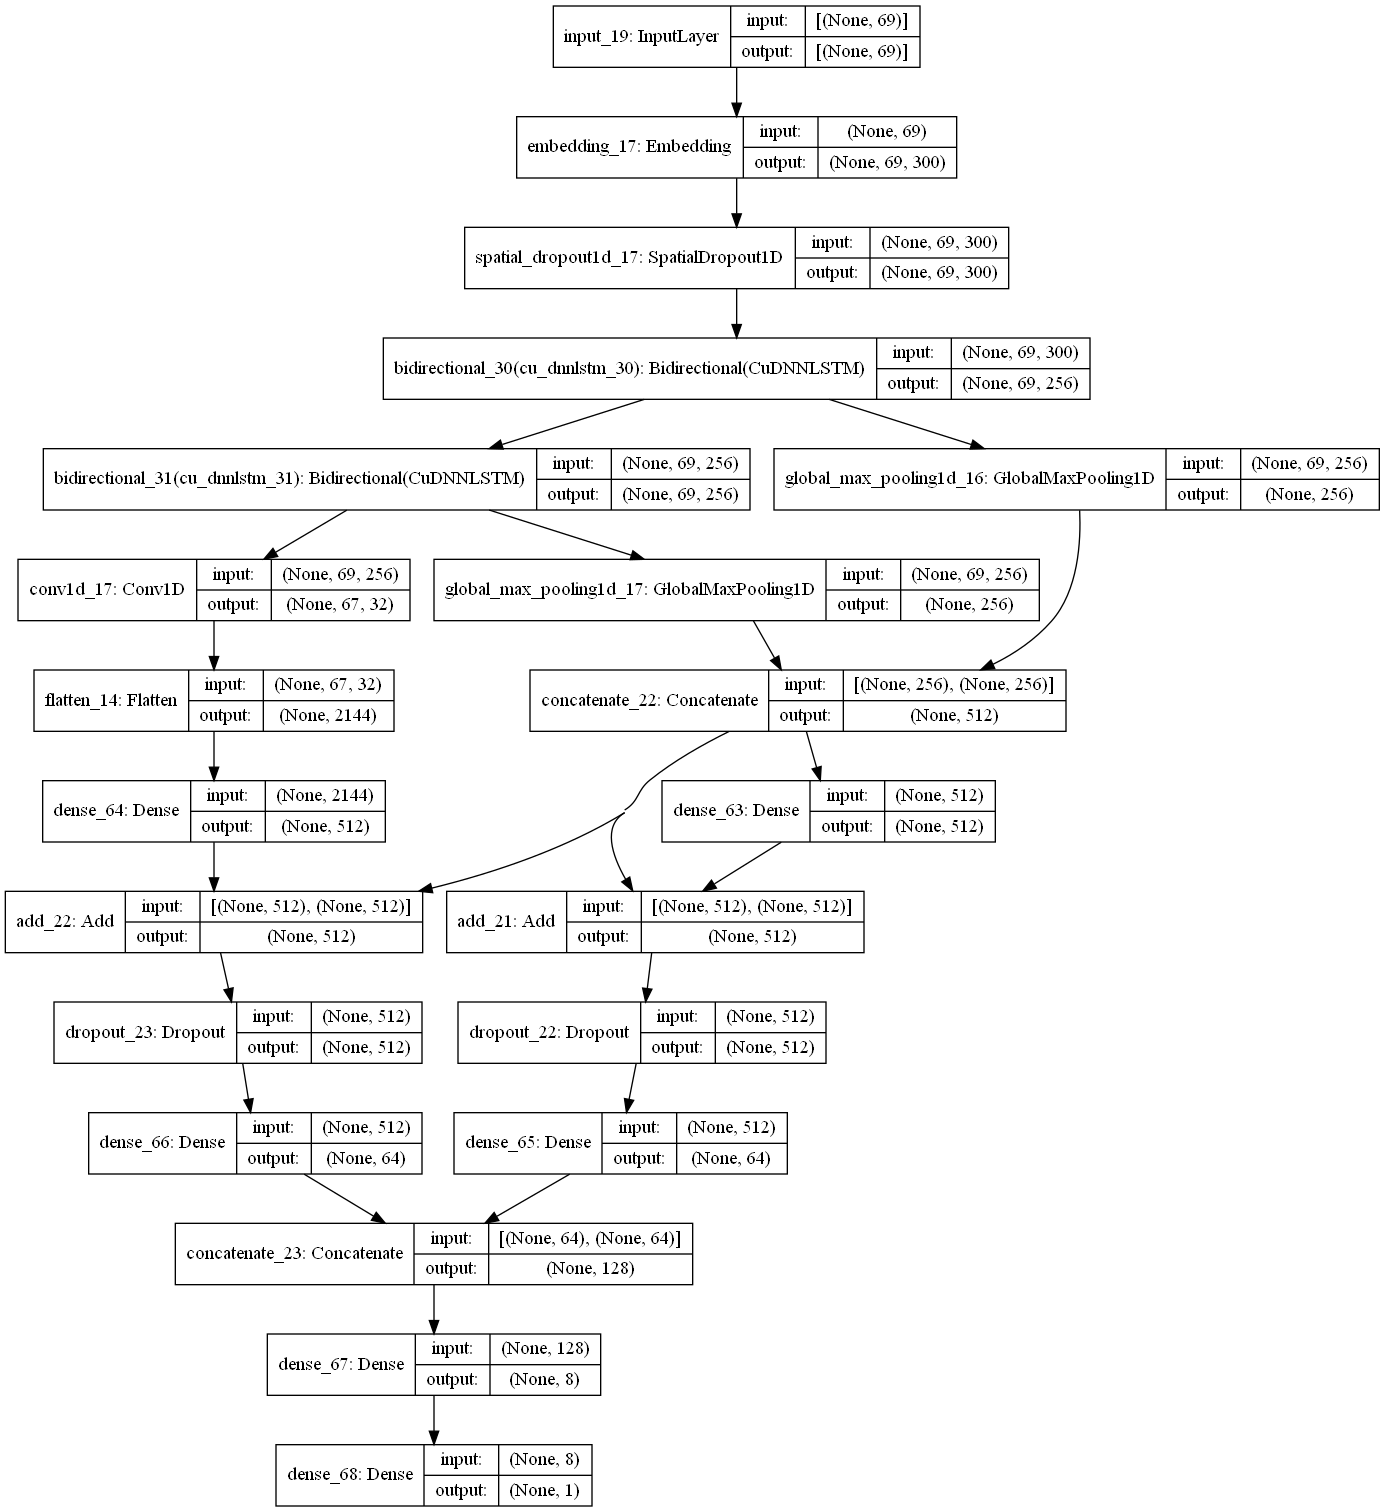

In [100]:
plot_model(Model_LSTM, to_file='Model_LSTM.png', show_shapes=True, show_layer_names=True)

In [101]:
Model_LSTM.compile(loss='binary_crossentropy', optimizer='adam') 

In [102]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_cv = encoder.transform(y_cv)
y_test = encoder.transform(y_test)

In [103]:
from keras.callbacks import ModelCheckpoint

In [104]:
#create callback
filepath = 'my_best_model_6_.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]


In [79]:
history=Model_LSTM.fit(x_train_padding, y_train,
           batch_size=256,
           epochs=6,
           validation_data=(x_cv_padding, y_cv),callbacks=callbacks)

Epoch 1/6
5075/5075 [==============================] - 166s 32ms/step - loss: 0.1552 - val_loss: 0.1358

Epoch 00001: val_loss improved from inf to 0.13580, saving model to my_best_model_6.hdf5


C:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/6
5075/5075 [==============================] - 158s 31ms/step - loss: 0.1390 - val_loss: 0.1345

Epoch 00002: val_loss improved from 0.13580 to 0.13451, saving model to my_best_model_6.hdf5
Epoch 3/6
5075/5075 [==============================] - 158s 31ms/step - loss: 0.1349 - val_loss: 0.1314

Epoch 00003: val_loss improved from 0.13451 to 0.13142, saving model to my_best_model_6.hdf5
Epoch 4/6
5075/5075 [==============================] - 158s 31ms/step - loss: 0.1323 - val_loss: 0.1313

Epoch 00004: val_loss improved from 0.13142 to 0.13126, saving model to my_best_model_6.hdf5
Epoch 5/6
5075/5075 [==============================] - 162s 32ms/step - loss: 0.1304 - val_loss: 0.1312

Epoch 00005: val_loss improved from 0.13126 to 0.13122, saving model to my_best_model_6.hdf5
Epoch 6/6
5075/5075 [==============================] - 164s 32ms/step - loss: 0.1287 - val_loss: 0.1312

Epoch 00006: val_loss improved from 0.13122 to 0.13117, saving model to my_best_model_6.hdf5


In [106]:
#Load and evaluate the best model version
from keras.models import load_model
model_6_load = load_model(filepath)

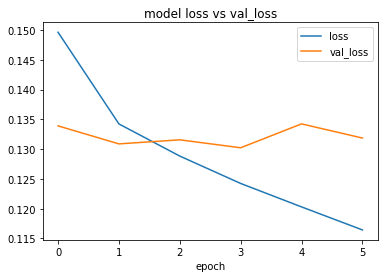

In [107]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss vs val_loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show() 

In [108]:
# https://stackoverflow.com/questions/68971378/attributeerror-sequential-object-has-no-attribute-predict-proba

#Probability belong to class 1

Model_LSTM_predict_proba_test = model_6_load.predict(x_test_padding)
Model_LSTM_predict_proba_train = model_6_load.predict(x_train_padding)

In [109]:
Model_LSTM_predict_proba_test = Model_LSTM_predict_proba_test.reshape(Model_LSTM_predict_proba_test.shape[0])
# Model_LSTM_predict_proba_train = Model_LSTM_predict_proba_train.reshape(Model_LSTM_predict_proba_train.shape[0])

In [110]:
x_test.shape

(269687, 48)

In [111]:
x_test['Model_LSTM_predict_proba_test'] = Model_LSTM_predict_proba_test

In [112]:

Model_LSTM_predict_proba_test_0_5 = [1 if i>0.5 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9 = [1 if i>0.9 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9_7 = [1 if i>0.97 else 0 for i in Model_LSTM_predict_proba_test]

> Calculating Weighted AUC

In [113]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score


In [114]:
subgroup = parameters(x_test)
identity_columns = subgroup
MODEL_NAME = 'Model_LSTM_predict_proba_test'
TOXICITY_COLUMN  = 'class'
bias_metrics_df = compute_bias_metrics_for_model(x_test, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
AUC_test = get_final_metric(bias_metrics_df, calculate_overall_auc(x_test, MODEL_NAME))

In [115]:
print('weighted AUC on test :',AUC_test)

weighted AUC on test : 0.8902500408699647


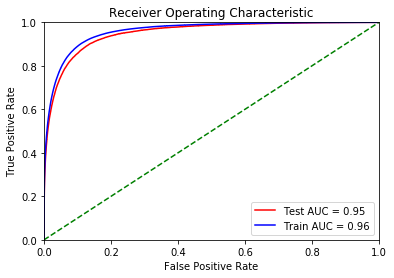

In [90]:
roc_auc_test,roc_auc_train,best_threshold_test,best_threshold_train = Plot_AUC_ROC_curve(y_test,y_train,Model_LSTM_predict_proba_test,Model_LSTM_predict_proba_train)

In [91]:
print('roc_auc_test simple: ',roc_auc_test)
print('roc_auc_train simple : ',roc_auc_train)
print('best_threshold_test : ',best_threshold_test)
print('best_threshold_train : ',best_threshold_train)

roc_auc_test simple:  0.9499586453939077
roc_auc_train simple :  0.9596324339429132
best_threshold_test :  0.08663607
best_threshold_train :  0.107881084


> Confusion matrix when threshold = 0.5

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

[[244159   3892]
 [  9595  12041]]


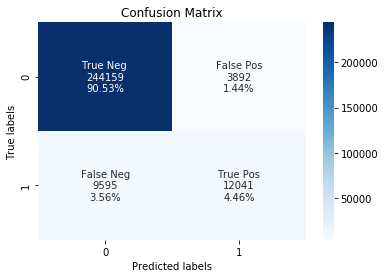

In [93]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_5)

[[247845    206]
 [ 16831   4805]]


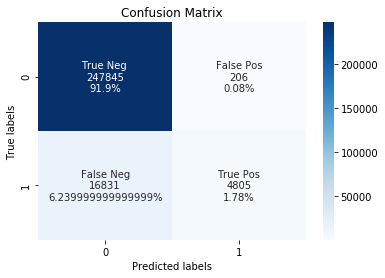

In [95]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_9)

> ## Model : 4
* CuDNNLSTM : 64 followed by 64
* Attention layer 

In [14]:
from keras.layers import Layer
import keras.backend as K

In [16]:

class Attention(Layer):
    def __init__(self, dec_features_dim, reg_value=0, **kwargs):
        """
        Layer to find context vector from the text sequences
        
        Arguments:
            dec_features_dim: Hidden decoder dimension
            reg_value       : Regularization value
            
        Inputs:
            x: text features of shape [220, 256]
        Outputs:
            Returns context vector for the text sequences of shape [256, ]
        """

        self.dec_features_dim = dec_features_dim
        self.reg_value        = reg_value

        self.enc = Dense(self.dec_features_dim, activation=None,\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))
        
        self.dec = Dense(1, activation=None,\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
  
        super(Attention, self).__init__(**kwargs)

    def call(self, x):
        """
        This method defines the main logic of Attention. It returns the context vector.
        
        Here, input x is the output from the bi-LSTM layer with return_sequences=True.
        Thus x is a 3D array of type (batch_size, step_dim, features_dim); features_dim = 2*LSTM_UNITS
        """

        # STEP 1. We calculate the alignment score using current decoder hidden state and each of the encoder’s hidden states.
        ei = self.enc(x)                            # [b, 220, 128]
        ei = self.dec(ei)                           # [b, 220, 1]
        ei = tf.keras.layers.Flatten()(ei)

        # STEP 2. We apply softmax to the alignment scores.
        ai = K.exp(ei)
        ai /= K.cast(K.sum(ai, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ai = K.expand_dims(ai)
        
        # STEP 3. Now we can find the alignment vectors by multiplying the encoder hidden states
        # with their respective alignment scores (x * a)
        weighted_input = x * ai                     # [batch_size, 220, 256]

        # STEP 4. Sum up the alignment vectors.
        # The alignment vectors are summed up along the step_dim dimension (second axis) to produce the context vector.
        return K.sum(weighted_input, axis=1)        #[batch_size, 256]
        
    def get_config(self):
        """
        This method collects the input shape and other information about the model.
        """
        config = {
            'dec_features_dim' : self.dec_features_dim,
            'reg_value' : self.reg_value
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
import os
os.environ['PYTHONHASHSEED'] = '0'

vocabulary_size = 111590+1

Model_input = Input(shape=(x_train_padding.shape[1],))
x = Embedding(vocabulary_size,output_dim=300,input_length=x_train_padding.shape[1],weights=[embedding_matrix], trainable=False)(Model_input)
x_ = SpatialDropout1D(0.2)(x)
x1 = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x_)
x2 = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x1)
attention_1 =  Attention(128)(x1)
attention_2 =  Attention(128)(x2)
max_pool1 = GlobalMaxPooling1D()(x1)
max_pool2 = GlobalMaxPooling1D()(x2)

conc = Concatenate()([attention_1,attention_2,max_pool1, max_pool2])
d0 = Dense(512,activation='relu')(conc)
adding_ = Add()([conc,d0])
d1 = Dense(512,activation='relu')(adding_)


# # Dropout_1 = Dropout(0.2, )(a1)
# d3 = Dense(1, activation='relu')(d1)

d2 = Dense(64, activation='relu')(d1)
Model_output = Dense(1,activation='sigmoid')(d2)
Model_LSTM= keras.Model(Model_input, Model_output)
Model_LSTM.summary()
# loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 69, 300)      33477300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 69, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 69, 128)      187392      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [18]:
from keras.utils.vis_utils import plot_model

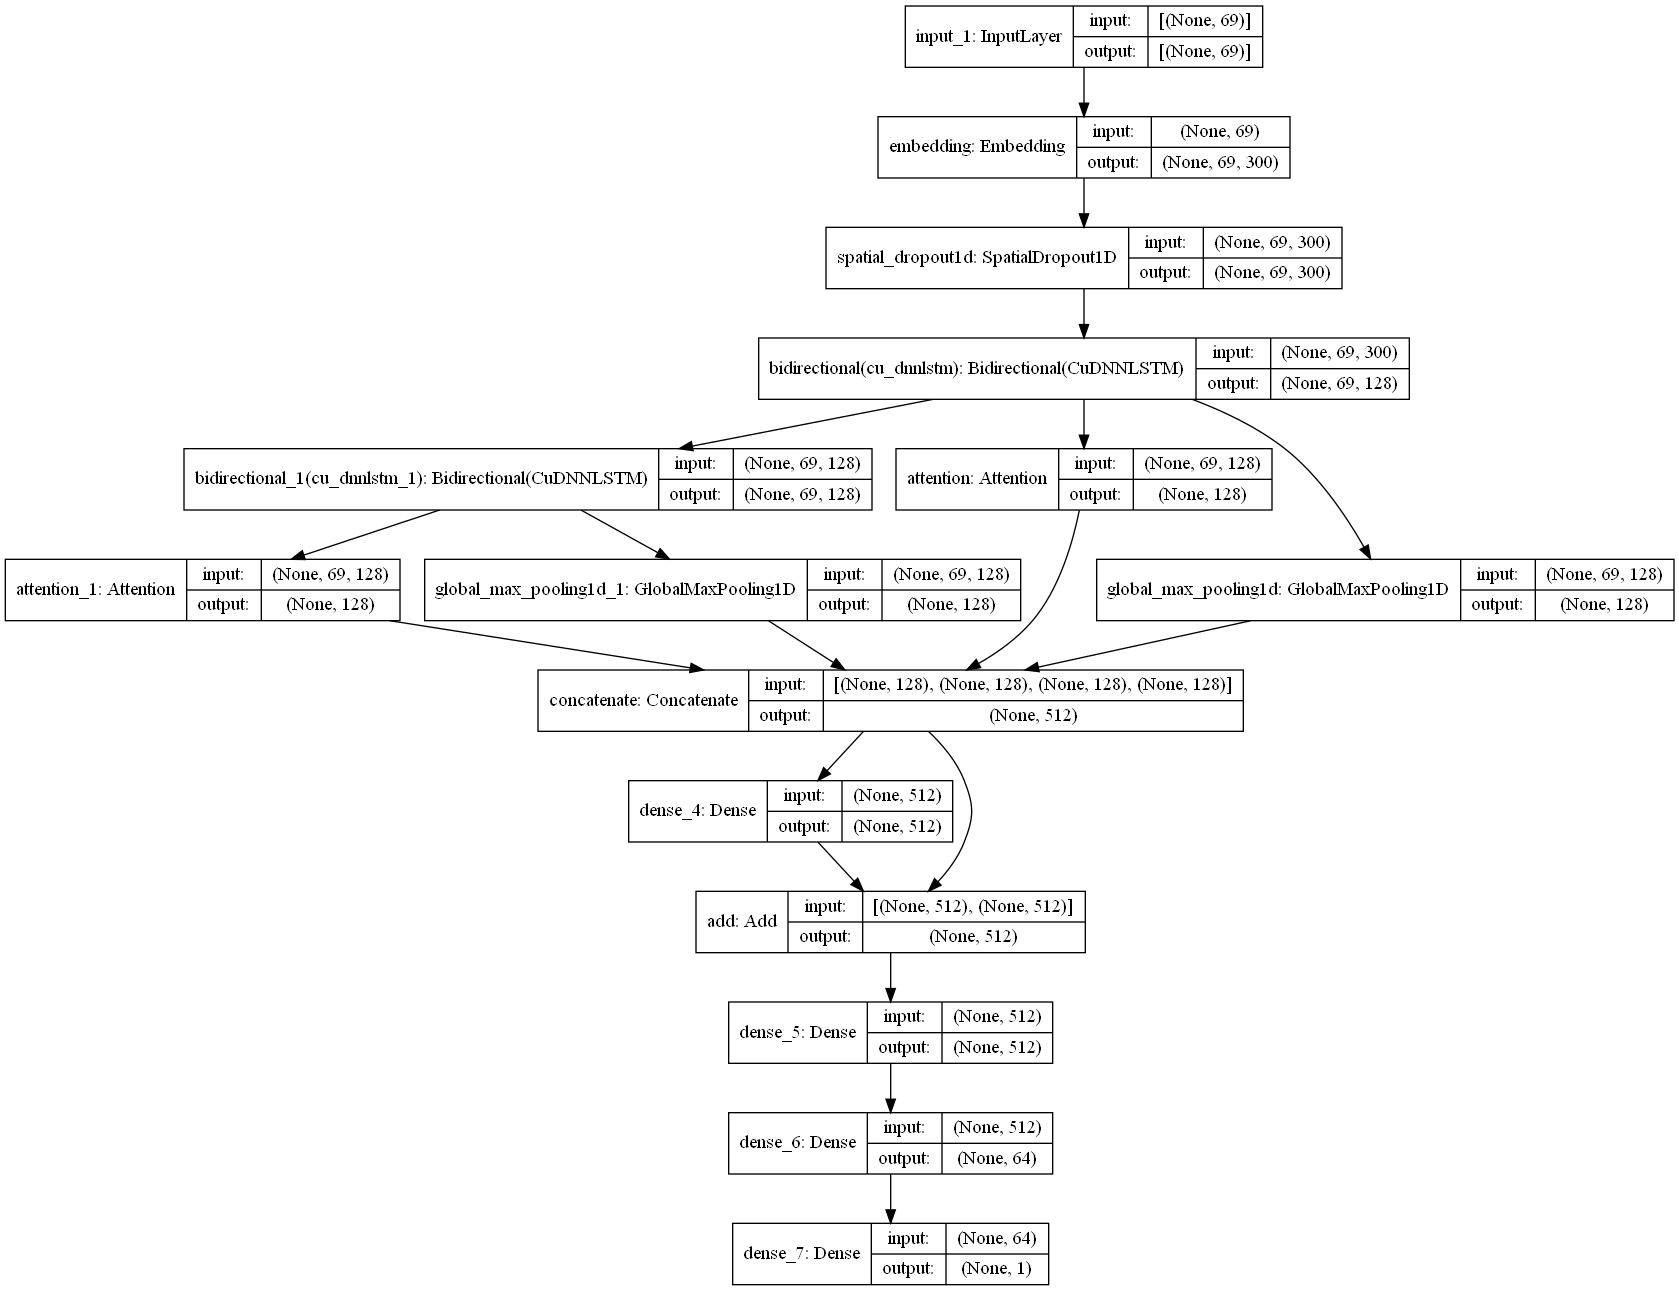

In [19]:
plot_model(Model_LSTM, to_file='Model_LSTM.png', show_shapes=True, show_layer_names=True)

In [20]:
Model_LSTM.compile(loss='binary_crossentropy', optimizer='adam') 

In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_cv = encoder.transform(y_cv)
y_test = encoder.transform(y_test)

In [22]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [23]:
#create callback
filepath = 'my_best_model_8_.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]


In [24]:
history=Model_LSTM.fit(x_train_padding, y_train,
           batch_size=256,
           epochs=6,
           validation_data=(x_cv_padding, y_cv),callbacks=callbacks)

Epoch 1/6
5075/5075 [==============================] - 276s 53ms/step - loss: 0.1485 - val_loss: 0.1344

Epoch 00001: val_loss improved from inf to 0.13444, saving model to my_best_model_8_.hdf5


C:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/6
5075/5075 [==============================] - 280s 55ms/step - loss: 0.1349 - val_loss: 0.1351

Epoch 00002: val_loss did not improve from 0.13444
Epoch 3/6
5075/5075 [==============================] - 266s 52ms/step - loss: 0.1303 - val_loss: 0.1306

Epoch 00003: val_loss improved from 0.13444 to 0.13060, saving model to my_best_model_8_.hdf5
Epoch 4/6
5075/5075 [==============================] - 270s 53ms/step - loss: 0.1271 - val_loss: 0.1301

Epoch 00004: val_loss improved from 0.13060 to 0.13010, saving model to my_best_model_8_.hdf5
Epoch 5/6
5075/5075 [==============================] - 274s 54ms/step - loss: 0.1245 - val_loss: 0.1298

Epoch 00005: val_loss improved from 0.13010 to 0.12982, saving model to my_best_model_8_.hdf5
Epoch 6/6
5075/5075 [==============================] - 262s 52ms/step - loss: 0.1222 - val_loss: 0.1320

Epoch 00006: val_loss did not improve from 0.12982


In [24]:
# #Load and evaluate the best model version
# from keras.models import load_model
# model_8_load = load_model(filepath)

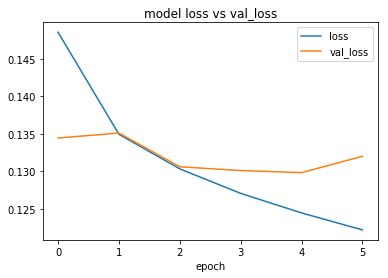

In [25]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss vs val_loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show() 

In [26]:
# https://stackoverflow.com/questions/68971378/attributeerror-sequential-object-has-no-attribute-predict-proba

#Probability belong to class 1

Model_LSTM_predict_proba_test = Model_LSTM.predict(x_test_padding)
Model_LSTM_predict_proba_train = Model_LSTM.predict(x_train_padding)

In [27]:
Model_LSTM_predict_proba_test = Model_LSTM_predict_proba_test.reshape(Model_LSTM_predict_proba_test.shape[0])
# Model_LSTM_predict_proba_train = Model_LSTM_predict_proba_train.reshape(Model_LSTM_predict_proba_train.shape[0])

In [28]:
x_test.shape

(269687, 47)

In [29]:
x_test['Model_LSTM_predict_proba_test'] = Model_LSTM_predict_proba_test

In [30]:

Model_LSTM_predict_proba_test_0_5 = [1 if i>0.5 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9 = [1 if i>0.9 else 0 for i in Model_LSTM_predict_proba_test]

Model_LSTM_predict_proba_test_0_9_7 = [1 if i>0.97 else 0 for i in Model_LSTM_predict_proba_test]

> Calculating Weighted AUC

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score


In [32]:
subgroup = parameters(x_test)
identity_columns = subgroup
MODEL_NAME = 'Model_LSTM_predict_proba_test'
TOXICITY_COLUMN  = 'class'
bias_metrics_df = compute_bias_metrics_for_model(x_test, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
AUC_test = get_final_metric(bias_metrics_df, calculate_overall_auc(x_test, MODEL_NAME))

In [33]:
print('weighted AUC on test :',AUC_test)

weighted AUC on test : 0.891540905307781


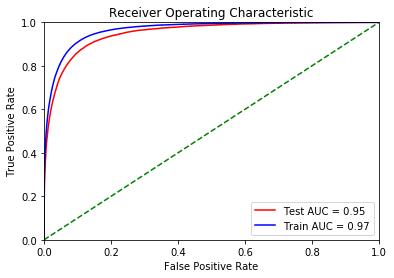

In [34]:
roc_auc_test,roc_auc_train,best_threshold_test,best_threshold_train = Plot_AUC_ROC_curve(y_test,y_train,Model_LSTM_predict_proba_test,Model_LSTM_predict_proba_train)

In [35]:
print('roc_auc_test simple: ',roc_auc_test)
print('roc_auc_train simple : ',roc_auc_train)
print('best_threshold_test : ',best_threshold_test)
print('best_threshold_train : ',best_threshold_train)

roc_auc_test simple:  0.9502494861849058
roc_auc_train simple :  0.9659245151288592
best_threshold_test :  0.09415189
best_threshold_train :  0.11540789


> Confusion matrix when threshold = 0.5

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

[[243195   4856]
 [  8858  12778]]


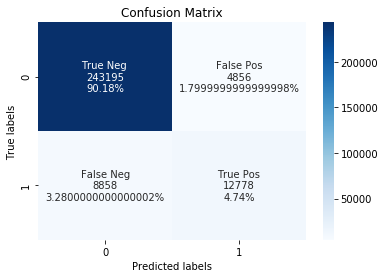

In [37]:
confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_5)

# confusion__matrix(y_test,Model_LSTM_predict_proba_test_0_9)

> Summery of all moodels

> Overall results

In [4]:
myTable = PrettyTable(['index',"Model ",'vectoriser', "Simpel AUC",'Weighted AUC','FP','FN'])
myTable.add_row(["1 ", "Bi_lstm_32_16","Glove_300","0.9497",'0.8923','2.53%','2.82%'])
myTable.add_row(["2 ", "Bi_lstm_128_128","Glove_300","0.9504",'0.8949','1.46%','3.55%'])
myTable.add_row(["3 ", "Bi_lstm_128_128_conv1D","Glove_300","0.9499",'0.8902','1.44%','3.56%'])
myTable.add_row(["4 ", "Bi_lstm_64_64_attention","Glove_300","0.9497",'0.8915','1.79%','3.28%'])
print(myTable)

+-------+-------------------------+------------+------------+--------------+-------+-------+
| index |          Model          | vectoriser | Simpel AUC | Weighted AUC |   FP  |   FN  |
+-------+-------------------------+------------+------------+--------------+-------+-------+
|   1   |      Bi_lstm_32_16      | Glove_300  |   0.9497   |    0.8923    | 2.53% | 2.82% |
|   2   |     Bi_lstm_128_128     | Glove_300  |   0.9504   |    0.8949    | 1.46% | 3.55% |
|   3   |  Bi_lstm_128_128_conv1D | Glove_300  |   0.9499   |    0.8902    | 1.44% | 3.56% |
|   4   | Bi_lstm_64_64_attention | Glove_300  |   0.9497   |    0.8915    | 1.79% | 3.28% |
+-------+-------------------------+------------+------------+--------------+-------+-------+


In [1]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(['index',"Model ",'vectoriser', "Simpel AUC",'Weighted AUC','FP','FN'])
  
# Add rows

myTable.add_row(["-- ", "-----",'----' ,"----",'----','----','----'])
myTable.add_row(["-- ", "ML_models",'----' ,"----",'----','----','----'])
myTable.add_row(["-- ", "-----",'----' ,"----",'----','----','----'])
myTable.add_row(["1 ", "Naive Bayes",'BOW' ,"0.8637",'0.7979','6.67%','3.29%'])
myTable.add_row(["2 ", "Naive Bayes",'TFIDF', "0.88223",'0.8420','0.03%','7.399%'])
myTable.add_row(["3 ", "Logistic regression",'BOW' ,"0.9177",'0.8711','0.94%','4.97%'])
myTable.add_row(["4 ", "Logistic regression",'TFIDF' ,"0.9345",'0.8831','1.09%','4.45%'])
myTable.add_row(["-- ", "-----",'----' ,"----",'----','----','----'])
myTable.add_row(["-- ", "DL_models",'----' ,"----",'----','----','----'])
myTable.add_row(["-- ", "-----",'----' ,"----",'----','----','----'])
myTable.add_row(["1 ", "Bi_lstm_32_16","Glove_300","0.9497",'0.8923','2.53%','2.82%'])
myTable.add_row(["2 ", "Bi_lstm_128_128","Glove_300","0.9504",'0.8949','1.46%','3.55%'])
myTable.add_row(["3 ", "Bi_lstm_128_128_conv1D","Glove_300","0.9499",'0.8902','1.44%','3.56%'])
myTable.add_row(["4 ", "Bi_lstm_64_64_attention","Glove_300","0.9497",'0.8915','1.79%','3.28%'])

# myTable.add_row(["-------", "-------", "-------"])



print(myTable)

+-------+-------------------------+------------+------------+--------------+-------+--------+
| index |          Model          | vectoriser | Simpel AUC | Weighted AUC |   FP  |   FN   |
+-------+-------------------------+------------+------------+--------------+-------+--------+
|  --   |          -----          |    ----    |    ----    |     ----     |  ---- |  ----  |
|  --   |        ML_models        |    ----    |    ----    |     ----     |  ---- |  ----  |
|  --   |          -----          |    ----    |    ----    |     ----     |  ---- |  ----  |
|   1   |       Naive Bayes       |    BOW     |   0.8637   |    0.7979    | 6.67% | 3.29%  |
|   2   |       Naive Bayes       |   TFIDF    |  0.88223   |    0.8420    | 0.03% | 7.399% |
|   3   |   Logistic regression   |    BOW     |   0.9177   |    0.8711    | 0.94% | 4.97%  |
|   4   |   Logistic regression   |   TFIDF    |   0.9345   |    0.8831    | 1.09% | 4.45%  |
|  --   |          -----          |    ----    |    ----    